<a href="https://colab.research.google.com/github/SharatGupta/DSML-Projects/blob/main/Zee_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

# Loading Data & Checking Structures

In [2]:
#!pip install gdown

In [3]:
!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 13.1MB/s]


In [4]:
!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 162MB/s]


In [5]:
!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 60.6MB/s]


In [6]:
movies=pd.read_fwf("zee-movies.dat",encoding='ISO-8859-1')

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [8]:
movies.shape

(3883, 3)

In [9]:
movies.head(5)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [10]:
ratings=pd.read_fwf("zee-ratings.dat",encoding='ISO-8859-1')

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [12]:
ratings.shape

(1000209, 1)

In [13]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [14]:
users=pd.read_fwf("zee-users.dat",encoding='ISO-8859-1')

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [16]:
users.shape

(6040, 1)

In [17]:
users.head(5)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


# Extracting Features from each Dataset

## Movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


Let drop the Columns with Incompletely Filled Data

### Adding Unnamed 1 & unnamed 2

In [19]:
movies[~movies["Unnamed: 1"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
235,238::Far From Home: The Adventures of Yellow D...,ren',NaN
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
...,...,...,...
3727,"3796::Wisdom of Crocodiles, The (a.k.a. Immort...",ille,NaN
3752,"3822::Girl on the Bridge, The (La Fille sur le...",ce,NaN
3785,"3855::Affair of Love, An (Une Liaison Pornogra...",nce,NaN
3794,3864::Godzilla 2000 (Gojira ni-sen mireniamu) ...,ci-F,NaN


In [21]:
movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 1"].isnull()]["Unnamed: 1"]

In [22]:
movies[~movies["Unnamed: 2"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
262,265::Like Water for Chocolate (Como agua para ...,oman,e
290,"293::Professional, The (a.k.a. Leon: The Profe...",ma|R,mance|Thriller
359,"363::Wonderful, Horrible Life of Leni Riefenst...",lder,(1993)::Docum
464,"468::Englishman Who Went Up a Hill, But Came D...",::Co,edy|Romance
740,750::Dr. Strangelove or: How I Learned to Stop...,b (1,63)::Sci-Fi|Wa
781,"791::Last Klezmer: Leopold Kozlowski, His Life...",cume,tary


In [23]:
movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 2"].isnull()]["Unnamed: 2"]

### OLD

In [ ]:
a= movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()
a.sum()

3783

In [ ]:
movies = movies[movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()]

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3783 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3783 non-null   object
 1   Unnamed: 1               0 non-null      object
 2   Unnamed: 2               0 non-null      object
dtypes: object(3)
memory usage: 118.2+ KB


In [ ]:
movies.drop(columns = ["Unnamed: 1","Unnamed: 2"], inplace=True)

In [ ]:
movies.shape

(3783, 1)

In [ ]:
movies.head(5)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


### splitting Features

In [24]:
movies.shape

(3883, 3)

In [26]:
movies["Movie ID"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
movies["Title"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
movies["Genres"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[-1])

In [27]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN,1,Toy Story (1995),Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN,3,Grumpier Old Men (1995),Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN,4,Waiting to Exhale (1995),Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN,5,Father of the Bride Part II (1995),Comedy


In [28]:
movies["Genres"] = movies["Genres"].str.split("|")

In [29]:
movies = movies.explode("Genres")

In [ ]:
movies.drop(columns= ["Movie ID::Title::Genres"], inplace = True)

In [32]:
movies.drop(columns= ["Unnamed: 1","Unnamed: 2"], inplace = True)

In [33]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Children's
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Children's


In [31]:
movies["Genres"]=movies["Genres"].astype("category")

In [34]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6366 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Movie ID::Title::Genres  6366 non-null   object  
 1   Movie ID                 6366 non-null   object  
 2   Title                    6366 non-null   object  
 3   Genres                   6366 non-null   category
dtypes: category(1), object(3)
memory usage: 207.9+ KB


In [ ]:
#Usage of Regex
def split_page(page):
    w = re.split('_|\.', page)
    print(w)
    return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

split_page('2NE1_zh.britanica.org_all-access_spider')

['2NE1', 'zh', 'britanica', 'org', 'all-access', 'spider']


('2NE1', 'zh', 'all-access', 'spider')

## Users

In [35]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [36]:
users["USerID"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[0])
users["Gender"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[1])
users["Age"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[2])
users["Occupation"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[3])
users["Zipcode"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[4])

In [37]:
users.drop(columns= ["UserID::Gender::Age::Occupation::Zip-code"], inplace = True)

In [38]:
users["Gender"]=users["Gender"].astype("category")
users["Occupation"]=users["Occupation"].astype("category")
users["Age"]=users["Age"].astype("category")
users["Zipcode"]=users["Zipcode"].astype("category")

In [39]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [40]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Ratings

In [41]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [42]:
ratings["USerID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[0])
ratings["Movie ID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[1])
ratings["Rating"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[2])
ratings["Timestamp"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[3])

In [43]:
ratings.drop(columns= ["UserID::MovieID::Rating::Timestamp"], inplace = True)

In [44]:
ratings["Rating"]=ratings["Rating"].astype("int")
ratings["Timestamp"]=ratings["Timestamp"].astype("int")

In [45]:
from datetime import datetime

In [46]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [47]:
ratings['dayofweek'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())

In [48]:
ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)
ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)

In [49]:
ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)

In [50]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [51]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


# Exploratory Data Analysis

## Movies

In [52]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Children's
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Children's


In [53]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID::Title::Genres are 3883
No of Unique Movie ID are 3883
No of Unique Title are 3883
No of Unique Genres are 88


In [54]:
movies["Genres"].value_counts()

Drama                                                                 1576
Comedy                                                                1184
Action                                                                 500
Thriller                                                               484
Romance                                                                453
                                                                      ... 
Music                                                                    1
Animati                                                                  1
My Life and Times With Antonin Artaud (En compagnie d'Antonin Arta       1
Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984        1
Wonderful, Horrible Life of Leni Riefenstahl, The (Die Macht der B       1
Name: Genres, Length: 88, dtype: int64

In [57]:
movies.loc[movies["Genres"] =="Horro","Genres"] = "Horror"
movies.loc[movies["Genres"] =="Fantas","Genres"] = "Fantasy"
movies.loc[movies["Genres"] =="Dram","Genres"] = "Drama"
movies.loc[movies["Genres"] =="Wester","Genres"] = "Western"
movies.loc[movies["Genres"] =="Sci-F","Genres"] = "Sci-Fi"
movies.loc[movies["Genres"] =="Thrille","Genres"] = "Thriller"
movies.loc[movies["Genres"] =="Wa","Genres"] = "War"

In [58]:
movies["Genres"].value_counts().reset_index()

,index,Genres
0,Drama,1579
1,Comedy,1184
2,Action,500
3,Thriller,485
4,Romance,453
...,...,...
83,Fantas,0
84,Dram,0
85,Wa,0
86,Wester,0


<Axes: xlabel='index', ylabel='Genres'>

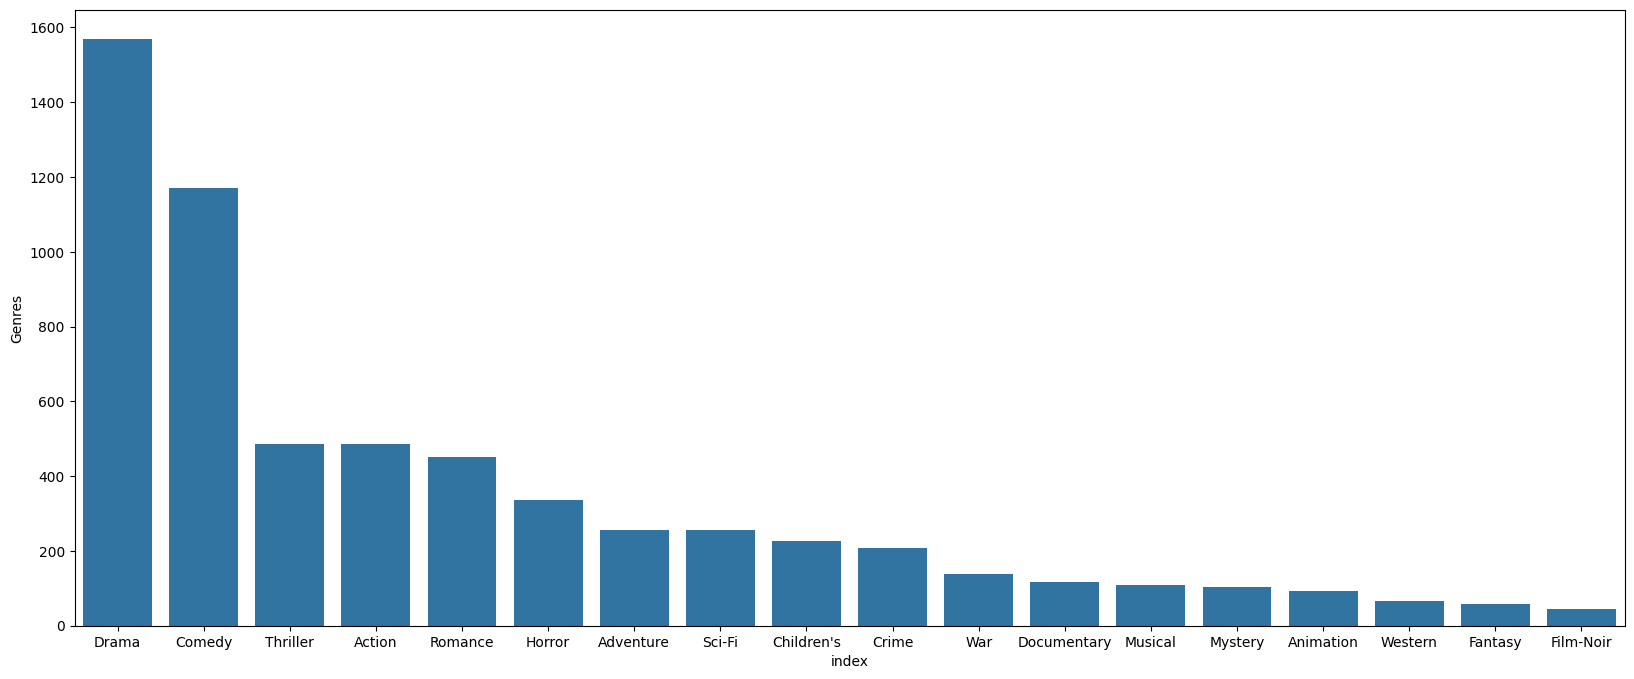

In [ ]:
plt.figure(figsize =(20,8))
sns.barplot(data= movies["Genres"].value_counts().reset_index(), x= "index", y="Genres")

In [ ]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 18


## Users

In [ ]:
for i in users.columns:
  print("No of Unique {} are {}".format(i,users[i].nunique()))

No of Unique USerID are 6040
No of Unique Gender are 2
No of Unique Age are 7
No of Unique Occupation are 21
No of Unique Zipcode are 3439


In [ ]:
users.shape

(6040, 5)

In [ ]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
Occup = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [ ]:
users["Occupation"].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

<Axes: xlabel='index', ylabel='Occupation'>

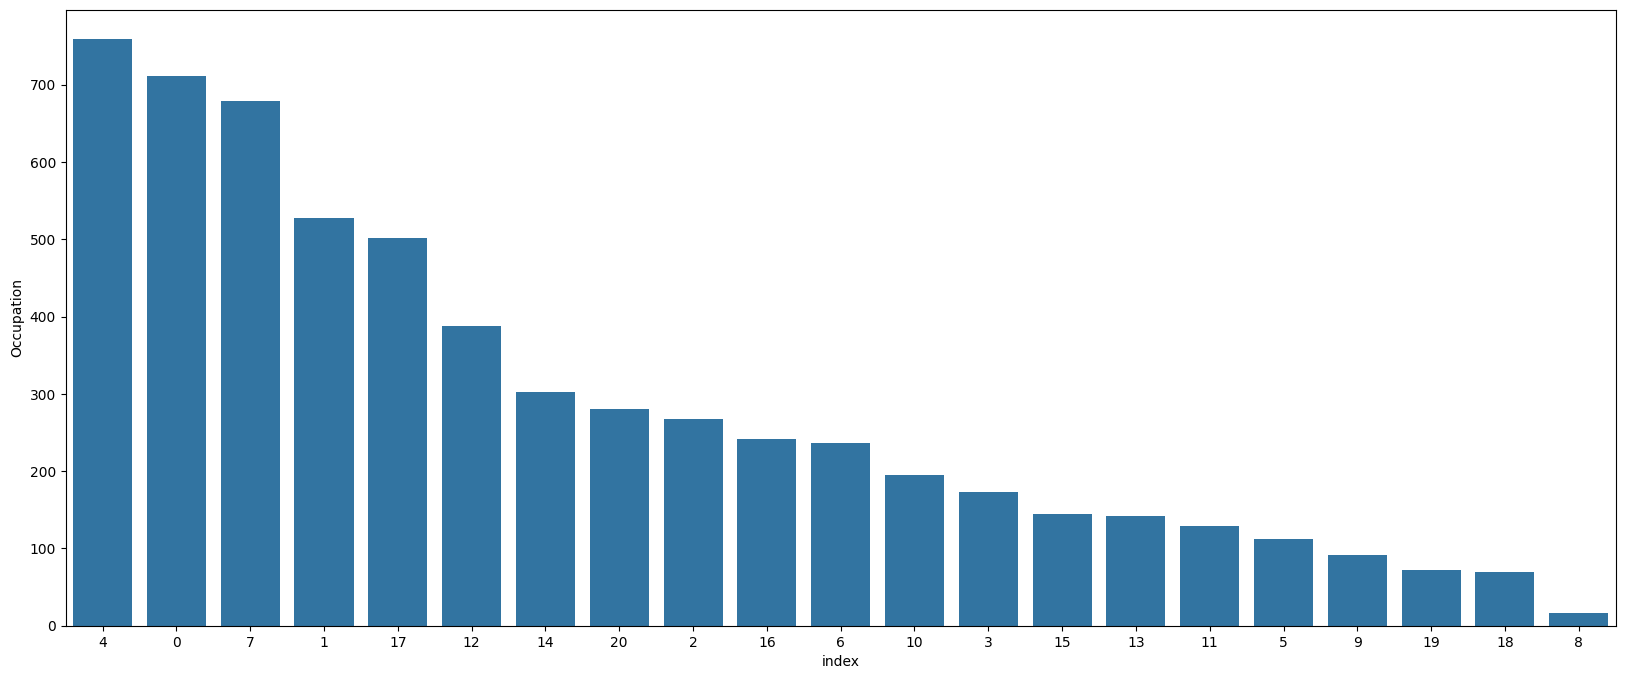

In [ ]:
plt.figure(figsize =(20,8))
sns.barplot(data= users["Occupation"].value_counts().reset_index(), x= "index", y="Occupation")

In [ ]:
users["Age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

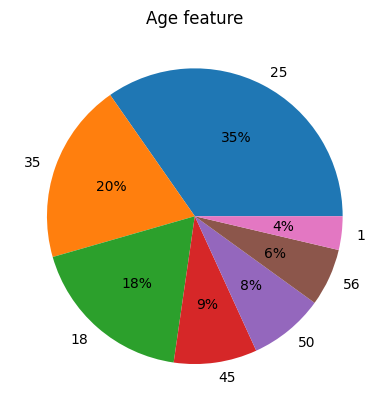

In [ ]:
plt.pie(x = users["Age"].value_counts().reset_index()["Age"],
        labels = users["Age"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Age feature")
plt.show()

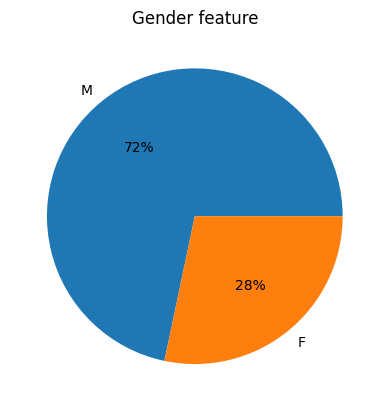

In [ ]:
plt.pie(x = users["Gender"].value_counts().reset_index()["Gender"],
        labels = users["Gender"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Gender feature")
plt.show()

In [ ]:
users["Zipcode"].value_counts().head(5)

48104    19
22903    18
55104    17
94110    17
55455    16
Name: Zipcode, dtype: int64

In [ ]:
users["Zipcode"].value_counts().tail(5)

80236    1
19428    1
33073    1
99005    1
14706    1
Name: Zipcode, dtype: int64

## Ratings

In [ ]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


In [ ]:
for i in ratings.columns:
  print("No of Unique {} are {}".format(i,ratings[i].nunique()))

No of Unique USerID are 6040
No of Unique Movie ID are 3706
No of Unique Rating are 5
No of Unique Timestamp are 458455
No of Unique hour are 24
No of Unique dayofweek are 7
No of Unique month are 12
No of Unique year are 4
No of Unique day are 31


In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
ratings["Rating"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

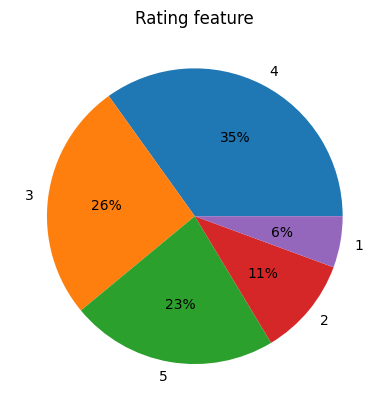

In [ ]:
plt.pie(x = ratings["Rating"].value_counts().reset_index()["Rating"],
        labels = ratings["Rating"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Rating feature")
plt.show()

<Axes: xlabel='hour', ylabel='count'>

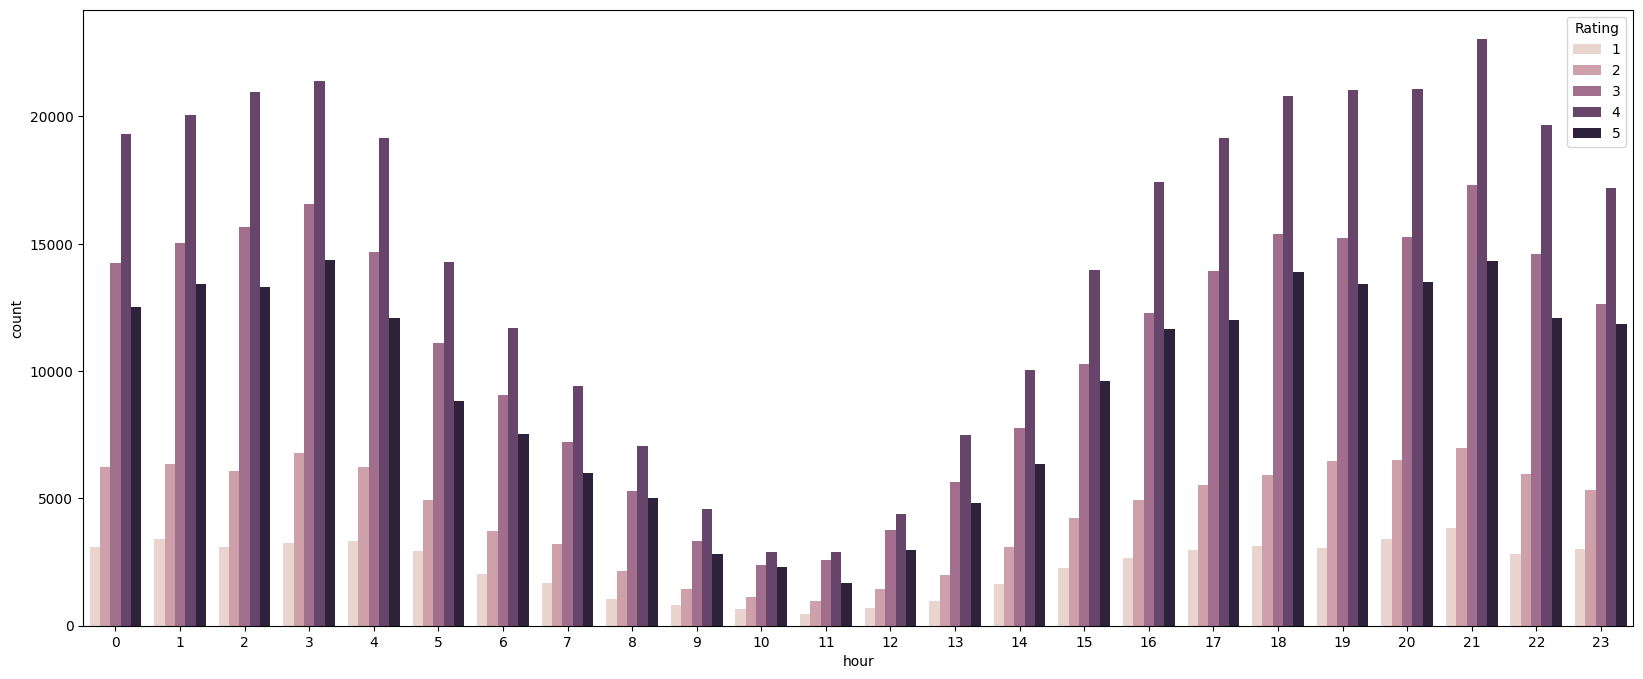

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "hour",hue = "Rating")

<Axes: xlabel='dayofweek', ylabel='count'>

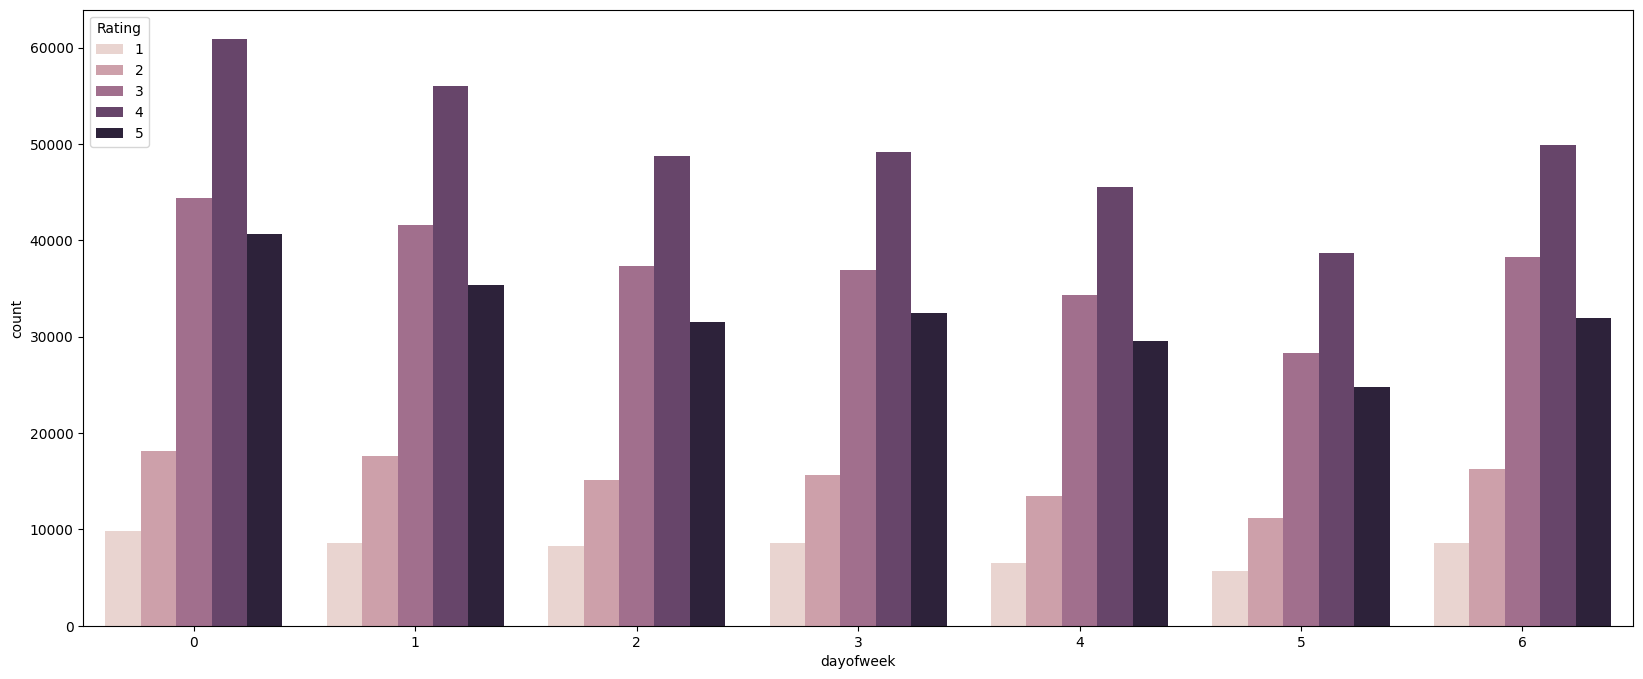

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "dayofweek",hue = "Rating")

<Axes: xlabel='month', ylabel='count'>

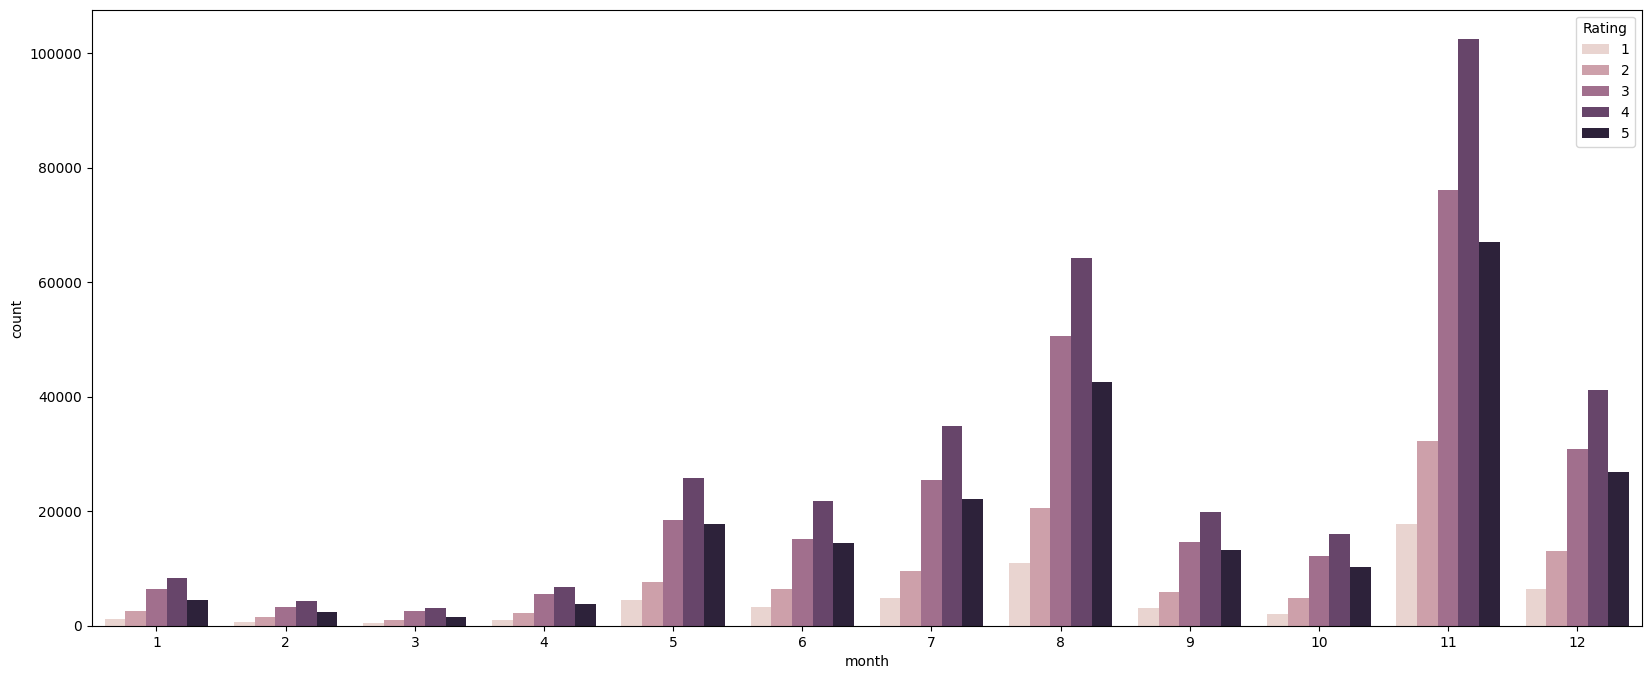

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "month",hue = "Rating")

<Axes: xlabel='year', ylabel='count'>

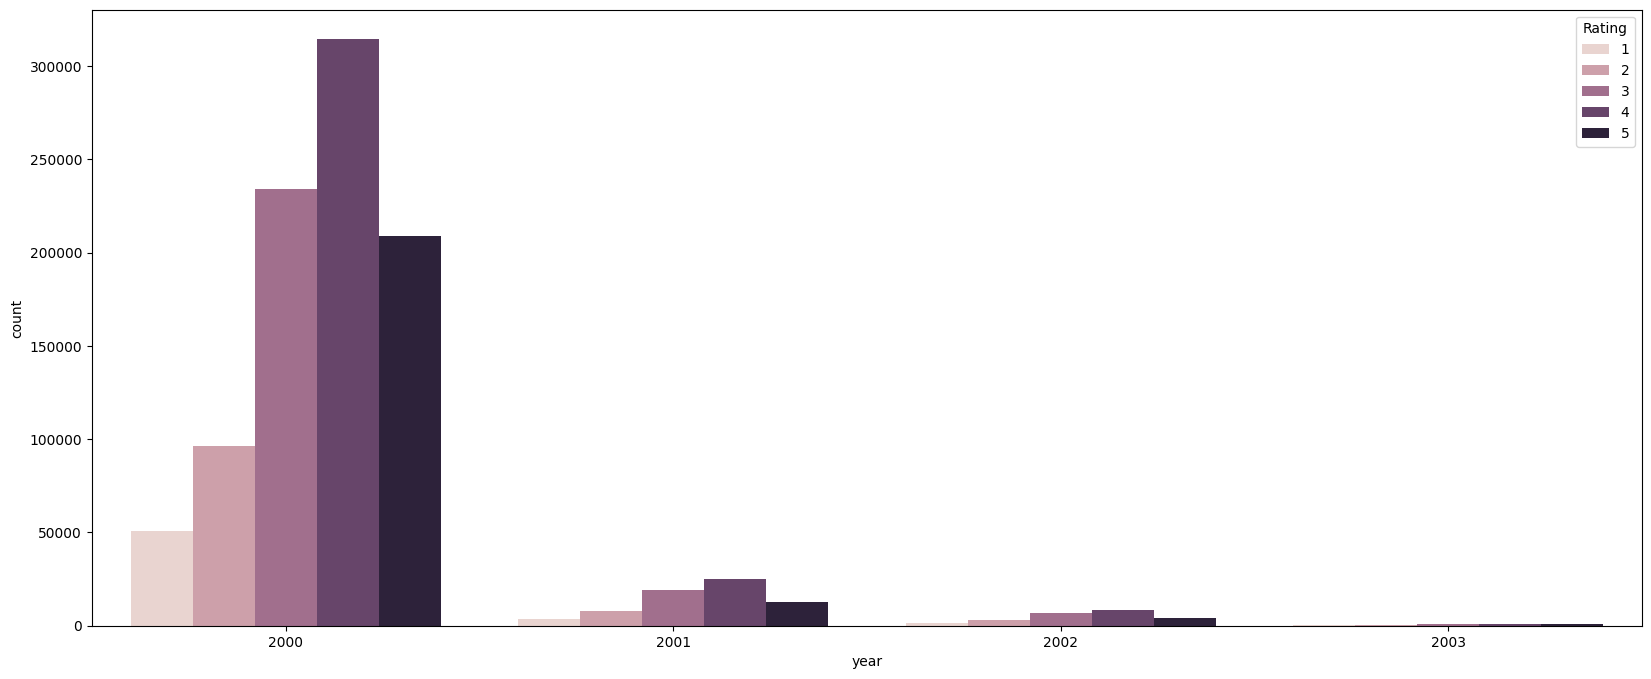

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "year",hue = "Rating")

In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [ ]:
ratings["Movie ID"].value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: Movie ID, Length: 3706, dtype: int64

In [ ]:
movies[movies["Movie ID"] == "260"]

,Movie ID,Title,Genres


# Merging the Datasets